In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [24]:
NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASS, cluster_std=1.5, random_state=RANDOM_SEED)

In [25]:
X_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

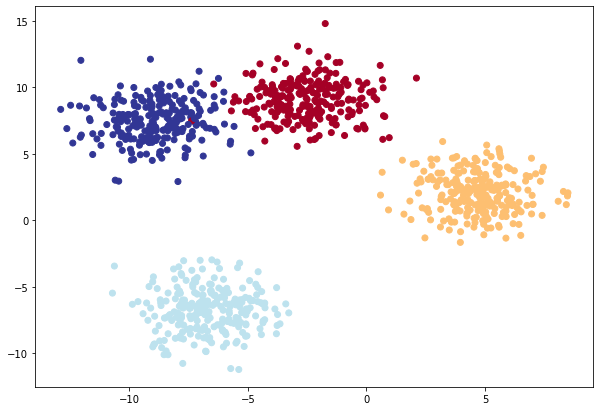

In [26]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c = y_blob, cmap=plt.cm.RdYlBu)

In [27]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [36]:
from torch import nn


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        x = self.linear_layer_stack(x)
        return x

In [37]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct/len(y_pred)*100
    return acc

In [38]:
model = BlobModel(NUM_FEATURES,NUM_CLASS).to(device)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [40]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [42]:
for epoch in range(epochs):
    model.train()
    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
    loss = loss_fn(y_logits,y_blob_train)
    acc = accuracy(y_pred, y_blob_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim=1)
        test_loss = loss_fn(test_logits,y_blob_test)
        test_acc = accuracy(test_pred,y_blob_test)
    if epoch%10 ==0 :
        print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}')

Epoch: 0 | Loss: 1.0432 | Acc: 65.50 | Test Loss: 0.5786 | Test Acc: 95.50
Epoch: 10 | Loss: 0.1440 | Acc: 99.12 | Test Loss: 0.1304 | Test Acc: 99.00
Epoch: 20 | Loss: 0.0806 | Acc: 99.12 | Test Loss: 0.0722 | Test Acc: 99.50
Epoch: 30 | Loss: 0.0592 | Acc: 99.12 | Test Loss: 0.0513 | Test Acc: 99.50
Epoch: 40 | Loss: 0.0489 | Acc: 99.00 | Test Loss: 0.0410 | Test Acc: 99.50
Epoch: 50 | Loss: 0.0429 | Acc: 99.00 | Test Loss: 0.0349 | Test Acc: 99.50
Epoch: 60 | Loss: 0.0391 | Acc: 99.00 | Test Loss: 0.0308 | Test Acc: 99.50
Epoch: 70 | Loss: 0.0364 | Acc: 99.00 | Test Loss: 0.0280 | Test Acc: 99.50
Epoch: 80 | Loss: 0.0345 | Acc: 99.00 | Test Loss: 0.0259 | Test Acc: 99.50
Epoch: 90 | Loss: 0.0330 | Acc: 99.12 | Test Loss: 0.0242 | Test Acc: 99.50


In [43]:
from helper_functions import plot_predictions, plot_decision_boundary

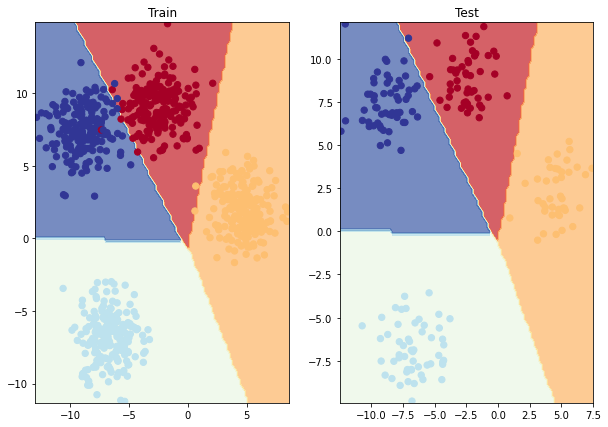

In [44]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model,X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_blob_test, y_blob_test)